## Deepmind Relation Network 
#### 이 글은 딥마인드의 A simple neural network module for relational reasoning 논문의 내용을 기반으로 만든 모델입니다.

관계추론(Relation Reasoning)이란 객체를 단순히 기호(문자열, 단어)로만 인식하는 것이 아니라 주어진 환경을 이해하고 인식하는 것. 
Relation Reasoning 은 예전부터 연구되어져 왔다.
* Symbolic approache : 관계추론을 언어학 수학적 방법으로 접근 하지만 symbol grounding problem(의미를 알지 못하고 단순히 기호로만 나열)
* Statistical learning : 통계학적 접근 하지만 Data-poor problem(object detect가 잘 안되는 현상) 발생<br></br>

관계추론의 예시 
* Non-relational question: (이미지 안에 4가지 과일이 있을때) 이건 뭐니? -> 과일 (단일 객체로 판단 가능.)
* Relational question: (이미지안에 4가지 과일이 있을 때) 과일중에 가장 큰 과일은 뭐니? -> 수박 (다른 객체와의 관계를 이해해야한다.)

#### Relation Networks
장점
* RNs learn to infer relations (RN 모델은 관계를 학습한다.)
* RNs are data efficient (g_function의 weight는 동일해서 효율적이다)
* RNs operate on a set of objects (RN 모델은 객체의 집합에서 작동한다)
* plug-and-play (모델을 이어서 간단하게 사용할 수 있다.)

RN 모델을 이용할 수 있는 예
* 환경(ex:이미지)안에서 각각의 object에 대한 관계를 설명할 수 있다.(Visual Question Answering (VQA))



$$ RN(O) = {f_\varnothing(\sum_{i,j} g_\theta(o_i,o_j,q))}$$

### Model 구조

![model](./model.png)

출처 : https://arxiv.org/pdf/1706.01427.pdf

Deepmind 에서 사용한 Visual Question Answering 데이터셋인 sort-of-CLEVR 가 제공되지 않아서 데이터셋을 만들어야 한다.

step 1: Convolution 을 이용하여 featuremap 형성 ( Fully connected 전까지 )<br></br>
step 2: Question을 LSTM 을 이용하여 마지막 Cell의 output을 featuremap 에서 뽑은 객체(O_i,O_j) 조합에 concat<br></br>
step 3: g(Relation) function 함수 만들기 (fully_connected)<br></br>
step 4: f(fully_connected) 로 output layer 만들기<br></br>

## MRI 이미지를 이용한 관계추론
* relational question = 손상부위가 가장 넓은 뇌의 위치를 알려줘 Where is the most damaged brain?
* non-relational question = 1번째 위치에 있는 뇌의 병을 맞춰봐 Guess the first brain disease.

### dataset 구성


![data_ex](./data_ex.jpg 'float:left')

출처 : http://www.med.harvard.edu/aanlib/

question data : relation question 과 non-relation question 두 종류의 질문<br></br>
label : one-hot 벡터로 구성<br></br>
노인 , 뇌혈관 질환을 가진 환자, 염증성 질환을 가진 환자, 뇌종양을 가진 환자의 M2 방식의 MRI 이미지를 병합하여 관계를 추론한다.<br></br>
이미지 데이터의 순서는 편중된 학습을 방지하기 위해 동일하지 않다.

In [1]:
import os
import numpy as np
import tensorflow as tf
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import math
import re
%matplotlib inline

### 이미지 읽어오기 

TOTAL 40 IMAGES LOADED.
('Image shape : ', (40, 196608))


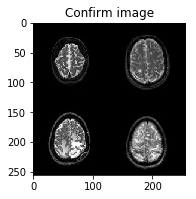

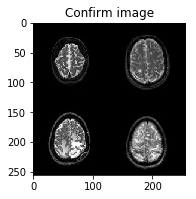

In [3]:
#set parameter
learning_rate = 0.001
training_epochs = 80
batch_size = 10


#sort image name list
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    
    return [ atoi(c) for c in re.split('(\d+)', text) ]


sess = tf.InteractiveSession()
path = './MRI/'
image_show = []
file_list = os.listdir(path)
file_list.sort(key=natural_keys)

n_image = 0


for f in file_list:
    fullpath = os.path.join(path,f)
    current_image = imread(fullpath)
    image_vec = np.reshape(current_image,(1,-1))
    if n_image is 0:
        train_image = image_vec
            
    else:
        train_image = np.concatenate((train_image,image_vec),axis=0)
            
    image_show.append(current_image)
    n_image = n_image +1

train_image = train_image[:]
    
print ("TOTAL %d IMAGES LOADED." %(n_image))     

    
print('Image shape : ',np.shape(train_image))

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(image_show[0])
    plt.title("Confirm image")
    plt.show()

###  LSTM 의 마지막 cell 의 output 의 array를 얻기위해 우선적으로 session 돌림.
* question_1 : Guess the oldest brain
* question_2 : Guess the first brain disease

단어를 one-hot 벡터로 만들고 질문의 문장의 길이가 길지 않기 때문에 RNN 으로 마지막 cell의 아웃풋 구함

In [4]:
# word one-hot encoding
Guess = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
the =   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
first  =[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
brain = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Where = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
image = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
of =    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
most =  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
widely =[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
damaged=[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


# RNN 의 마지막 cell의 아웃풋을 구한다.
hidden_size = 11
cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden_size)
q_1 = np.array([[Where, the, image, of, the, most, widely, damaged, brain]],dtype = np.float32)
q_2 = np.array([[Guess, the, first, brain]], dtype=np.float32)
outputs_1, _states = tf.nn.dynamic_rnn(cell, q_1, dtype=tf.float32)
outputs_2, _states = tf.nn.dynamic_rnn(cell, q_2, dtype=tf.float32)
sess.run(tf.global_variables_initializer())
last_cell_q1 = outputs_1.eval()[-1][-1]
last_cell_q2 = outputs_2.eval()[-1][-1]

print('question 1 : ',last_cell_q1)
print('question 2 : ',last_cell_q2)

question = []
for i in range(20):
    question.append(last_cell_q1)
    question.append(last_cell_q2)
    
print('question shape is ',np.shape(question))    


('question 1 : ', array([-0.30292931, -0.33118805, -0.01487852, -0.41434515,  0.2376757 ,
        0.24951918, -0.55060291, -0.46964431,  0.05010713,  0.18899693,
       -0.17924574], dtype=float32))
('question 2 : ', array([ 0.70719725, -0.61223662, -0.67631167, -0.58122647,  0.45219141,
        0.11561447, -0.390239  , -0.46781453,  0.32868204,  0.76509798,
       -0.37819871], dtype=float32))
('question shape is ', (40, 11))


### 정답 label 만들기

In [5]:
# answer = ['cerebrovasular', 'inflammatory', 'neoplastic','normalAging','왼쪽 위', '왼쪽 아래', '오른쪽 위', 오른쪽 아래']

answer = [[0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1,],[0,0,1,0,0,0,0,0],
          [0,0,0,0,0,0,0,1],[0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0],[1,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,0,1],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,1,0,0,0,0,0],
          [0,0,0,0,1,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,1,0,0,0,0,0],
          [0,0,0,0,1,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,1,0,0,0,0,0],
          [0,0,0,0,0,0,0,1],[0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,1],[1,0,0,0,0,0,0,0],
          [0,0,0,0,0,0,1,0],[1,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,0],[0,0,1,0,0,0,0,0],
          [0,0,0,0,0,0,1,0],[0,0,0,1,0,0,0,0],[0,0,0,0,0,0,0,1],[0,0,0,1,0,0,0,0],
          [0,0,0,0,0,1,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,1,0,0,0,0,0,0]]

print('Answer : ',np.shape(answer))

('Answer : ', (40, 8))


In [6]:
# X placeholder
X = tf.placeholder(tf.float32, [None, 256*256*3])

# qeustion placeholder
q = tf.placeholder(name='q', dtype=tf.float32, shape=[None, 11])

# answer placeholder 
a = tf.placeholder(name='a', dtype=tf.float32, shape=[None, 8])

# image reshape
X_img = tf.reshape(X, [-1, 256, 256, 3]) 

# dropout train:0.7 test:1.0
keep_prob = tf.placeholder(tf.float32)

### 첫번째 단계 5번의 컨볼루션

기본의 CNN의 Convolution layer 에는 sub-sampling 으로 max-pooling이 사용되었지만 RN에서는 사용하지 않았다.
이유는 아마 Object의 특성들을 최대한 살리기 위해서 인듯하다.<br></br>
또한 마지막 featuremap에서 fully-connected로 바로가지 않는다.
* kernal size , strides : 임의로 조정함
* conv_1 : 5 by 5 , 3
* conv_2 : 3 by 3 , 3
* conv_3 : 3 by 3 , 2
* conv_4 : 3 by 3 , 2
* conv_5 : 3 by 3 , 2<br></br>

차이점 : Deepmind 의 경우 dropout 대신 batch normalization

### 시각화
#### getActivation , plotNNFilter 시각화함수
Relational network 의 경우 이미지 원본에서 보여지는 객체들을 뽑아내는게 아니라 convolution된 마지막 n 개의 featuremap에서 위치가 같은 n개의 픽셀이 한 object가 된다. 따라서 어떻게 object로 인식되어질 수 있는지 파악하기 위해 시각화를 해본다.   

In [7]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={X:np.reshape(stimuli,[1,196608],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [8]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(10,10))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [9]:
#conv_1
weight_1 = tf.Variable(tf.random_normal([5, 5, 3, 24], stddev=0.01))
conv_1 = tf.nn.conv2d(X_img, weight_1, strides=[1, 3, 3, 1], padding='SAME')
conv_1 = tf.nn.relu(conv_1)
conv_1 = tf.nn.dropout(conv_1, keep_prob=keep_prob)

print(conv_1)

#conv_2
weight_2 = tf.Variable(tf.random_normal([3, 3, 24, 24], stddev=0.01))
conv_2 = tf.nn.conv2d(conv_1, weight_2, strides=[1, 3, 3, 1], padding='SAME')
conv_2 = tf.nn.relu(conv_2)
conv_2 = tf.nn.dropout(conv_2, keep_prob=keep_prob)
print(conv_2)

#conv_3
weight_3 = tf.Variable(tf.random_normal([3, 3, 24, 24], stddev=0.01))
conv_3 = tf.nn.conv2d(conv_2, weight_3, strides=[1, 2, 2, 1], padding='SAME')
conv_3 = tf.nn.relu(conv_3)
conv_3 = tf.nn.dropout(conv_3, keep_prob=keep_prob)
print(conv_3)

#conv_4
weight_4= tf.Variable(tf.random_normal([3, 3, 24, 24], stddev=0.01))
conv_4= tf.nn.conv2d(conv_3, weight_4, strides=[1, 2, 2, 1], padding='SAME')
conv_4= tf.nn.relu(conv_4)
conv_4= tf.nn.dropout(conv_4, keep_prob=keep_prob)
print(conv_4)

#conv_5
weight_5= tf.Variable(tf.random_normal([3, 3, 24, 24], stddev=0.01))
conv_5= tf.nn.conv2d(conv_4, weight_5, strides=[1, 2, 2, 1], padding='SAME')
conv_5= tf.nn.relu(conv_5)
conv_5= tf.nn.dropout(conv_5, keep_prob=keep_prob)
print(conv_5)


Tensor("dropout/mul:0", shape=(?, 86, 86, 24), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 29, 29, 24), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 15, 15, 24), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 8, 8, 24), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 4, 4, 24), dtype=float32)


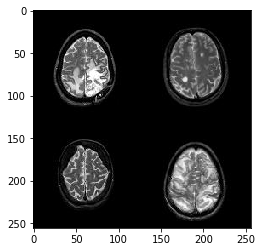

In [11]:
plt.imshow(np.reshape(train_image[2],[256,256,3]), interpolation="nearest", cmap="gray")

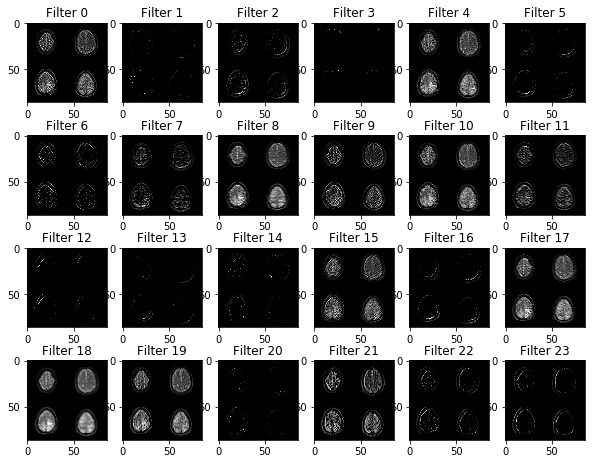

In [12]:
sess.run(tf.global_variables_initializer())
getActivations(conv_1,train_image[0])

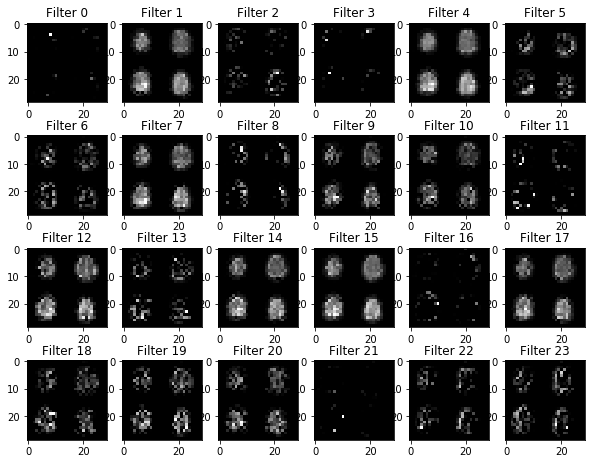

In [13]:
getActivations(conv_2,train_image[0])

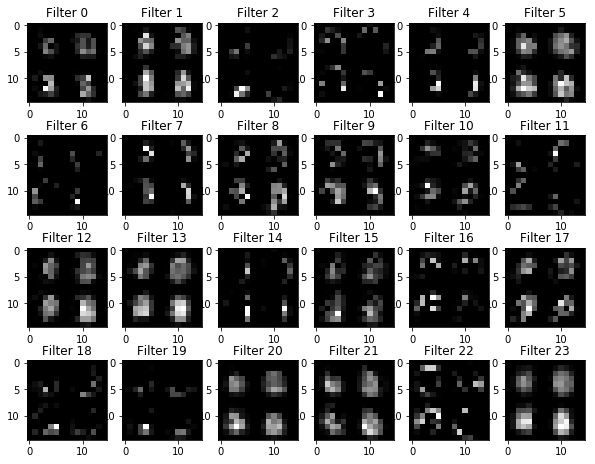

In [14]:
getActivations(conv_3,train_image[0])

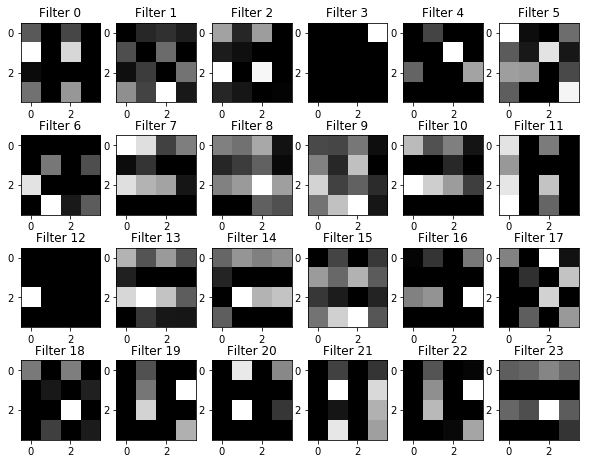

In [15]:
getActivations(conv_5,train_image[0])

In [16]:
# d 는 마지막 con_5로 인해 만들어지는 featuremap의 가로 or 세로 길이
d = conv_5.get_shape().as_list()[1]
all_g =[]

### RN 수식 구현하기
$$ RN(O) = {f_\varnothing(\sum_{i,j} g_\theta(o_i,o_j,q))}$$

concat_coor 함수 : featuremap 에서 뽑은 object 에서 object 순서쌍을 정보를 concat 한다.<br></br>
g_theta 함수 : concat_coor 함수로 결정된 O_i, O_j 에 q(question)을 concat하고 fully_connected 진행<br></br>
fc 함수 : fully-connected <br></br>
f_phi 함수 : fully-connected

In [17]:
# q shape n,11
# 따라서 O_i, O_j, q 를 concat 하면  8 , 24+24+11 
def g_theta(o_i, o_j, q):
    g_1 = fc(tf.concat([o_i, o_j, q], axis=1), 256, name='g_1')
    g_2 = fc(g_1, 256, name='g_2')
    g_3 = fc(g_2, 256, name='g_3')
    g_4 = fc(g_3, 256, name='g_4')
    return g_4

In [18]:
# Fully-connected
def fc(input, output_shape, activation_fn=tf.nn.relu, name="fc"):
    output = slim.fully_connected(input, int(output_shape), activation_fn=activation_fn)
    return output

In [19]:
# 객체의 모든 쌍에대해 g_function 해준 결과를 마지막으로 mlp 사용해서 최종적으로 output 개수만큼 뽑기
def f_function(g):
    fc_1 = fc(g, 256, name='fc_1')
    fc_2 = fc(fc_1, 256, name='fc_2')
    fc_2 = slim.dropout(fc_2, keep_prob=0.5, is_training=True, scope='fc_3/')
    # n = number of label 
    fc_3 = fc(fc_2, 8 , activation_fn=None, name='fc_3')
    return fc_3

In [20]:
#객체 추출하고 g(relation function) 계산
# i : 0~16 j : 0~16
for i in range(d*d):
    o_i = conv_5[:, int(i / d), int(i % d), :]
    
    for j in range(d*d):
        o_j = conv_5[:, int(j / d), int(j % d), :]
        
        if i == 0 and j == 0:
            g_i_j = g_theta(o_i, o_j, q)
        elif i !=j :
            g_i_j = g_theta(o_i, o_j, q)
        all_g.append(g_i_j)

all_g = tf.stack(all_g, axis=0)
all_g = tf.reduce_sum(all_g, axis=0, name='all_g')
g = all_g
print(g)

Tensor("all_g:0", shape=(?, 256), dtype=float32)


In [21]:
#hypothesis
logits = f_function(g)

In [22]:
def build_loss(logits, labels):
    # Cross-entropy loss
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)

    # Classification accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return tf.reduce_mean(loss), accuracy

In [23]:
loss,accuracy = build_loss(logits,a)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
sess.run(tf.global_variables_initializer())

### Learning start

In [24]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int( n_image / batch_size)

    for i in range(total_batch):
        feed_dict = {X: train_image, q: question, a:answer , keep_prob: 0.7}
        c, _ ,accuracy_= sess.run([loss, optimizer,accuracy], feed_dict=feed_dict)
        avg_cost += c / total_batch
    if epoch % 10 == 0:
        print('Epoch :', '%04d' % (epoch), 'cost =', '{:.9f}'.format(avg_cost))
        print('Train Accuracy : ', accuracy_)
print('Finished')


('Epoch :', '0000', 'cost =', '4.854063690')
('Train Accuracy : ', 0.27500001)
('Epoch :', '0010', 'cost =', '1.382609665')
('Train Accuracy : ', 0.42500001)
('Epoch :', '0020', 'cost =', '0.661246374')
('Train Accuracy : ', 0.77499998)
('Epoch :', '0030', 'cost =', '0.429346286')
('Train Accuracy : ', 0.85000002)
('Epoch :', '0040', 'cost =', '0.055451158')
('Train Accuracy : ', 1.0)
('Epoch :', '0050', 'cost =', '0.084944320')
('Train Accuracy : ', 1.0)
('Epoch :', '0060', 'cost =', '0.192248608')
('Train Accuracy : ', 0.92500001)
('Epoch :', '0070', 'cost =', '0.147692071')
('Train Accuracy : ', 1.0)
Finished


### Predict

Question 1 : 가장 넓게 손상된 뇌는 어디에 위치해 있니?
Answer 1 : 오른쪽 아래에 위치해 있습니다.
Question 2 : 1번째 뇌의 질병을 알려줘
Answer 2 : Aging 입니다.


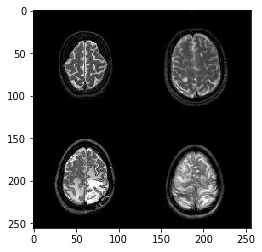

In [26]:
# answer = ['cerebrovasular', 'inflammatory', 'neoplastic','normalAging','왼쪽 위', '왼쪽 아래', '오른쪽 위', 오른쪽 아래']
plt.imshow(np.reshape(train_image[0],[256,256,3]), interpolation="nearest", cmap="gray")
result_1 = sess.run(tf.argmax(logits, 1), feed_dict={X: train_image[0: 1],q:question[0:1], keep_prob: 1})
result_2 = sess.run(tf.argmax(logits, 1), feed_dict={X: train_image[1: 2],q:question[1:2], keep_prob: 1})
print('Question 1 : 가장 넓게 손상된 뇌는 어디에 위치해 있니?')
if 7 in result_1:
    print('Answer 1 : 오른쪽 아래에 위치해 있습니다.')
print('Question 2 : 1번째 뇌의 질병을 알려줘')
if 0 in result_2:
    print('Answer 2 : Aging 입니다.')